In [22]:
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


In [40]:
import tensorflow_datasets as tfds

# Load the splits
splits = tfds.load(
    'imdb_reviews',
    split=['train[:80%]', 'train[80%:]', 'test'],
    as_supervised=True,
)

train_ds, val_ds, test_ds = splits


In [41]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)


In [42]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"




In [43]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1)(net)
    return tf.keras.Model(text_input, net)


In [44]:
classifier_model = build_classifier_model()


In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)


In [46]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)
history = classifier_model.fit(train_ds, validation_data=val_ds, callbacks=[early_stop], epochs = 2)


Epoch 1/3
625/625 [==============================] - 1144s 2s/step - loss: 0.6905 - binary_accuracy: 0.5404 - val_loss: 0.6632 - val_binary_accuracy: 0.5396
Epoch 2/3
625/625 [==============================] - 1133s 2s/step - loss: 0.6646 - binary_accuracy: 0.5660 - val_loss: 0.6436 - val_binary_accuracy: 0.5646
Epoch 3/3
625/625 [==============================] - 1130s 2s/step - loss: 0.6458 - binary_accuracy: 0.5912 - val_loss: 0.6288 - val_binary_accuracy: 0.5848


In [47]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']


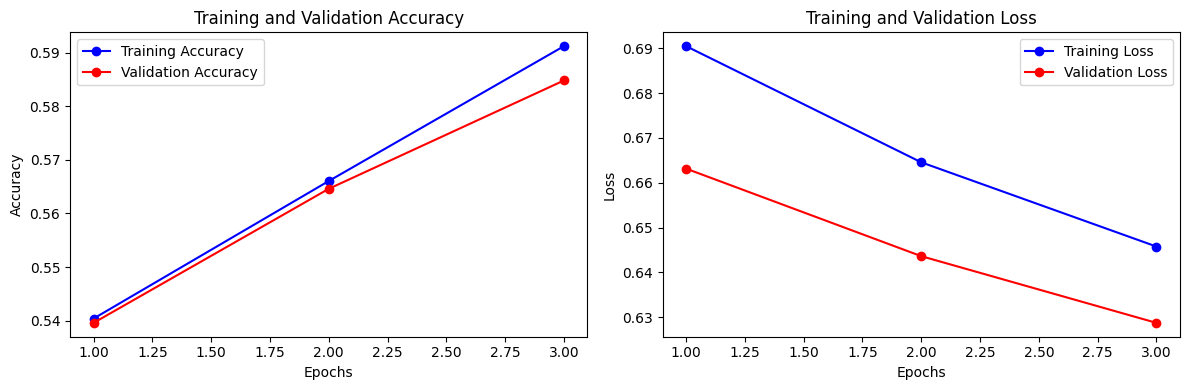

In [48]:
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
def predict_sentiment(text_list):
    predictions = tf.sigmoid(classifier_model(tf.constant(text_list)))
    for text, score in zip(text_list, predictions):
        label = "Positive" if score > 0.5 else "Negative"
        print(f"\nInput: {text}")
        print(f"Predicted Sentiment: {label} (Score: {score.numpy()[0]:.4f})")

In [51]:
sample_reviews = [
    "It was a waste of time.",
    "Quite boring and slow.",
    "Absolutely amazing experience.",
    "I have mixed feelings about this film."
]

predict_sentiment(sample_reviews)



Input: It was a waste of time.
Predicted Sentiment: Negative (Score: 0.1885)

Input: Quite boring and slow.
Predicted Sentiment: Negative (Score: 0.3450)

Input: Absolutely amazing experience.
Predicted Sentiment: Positive (Score: 0.5370)

Input: I have mixed feelings about this film.
Predicted Sentiment: Positive (Score: 0.5586)
